In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

360


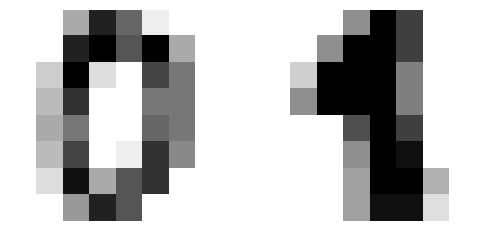

In [3]:
# Load digits dataset
digits = datasets.load_digits(n_class=2)
print(len(digits.images))
# Plot example '0' and '1'
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[100], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [6]:
# Split dataset
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# Reduce dimensions
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)
print(sample_train[0])
# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)
print(sample_train[0])
# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)
print(sample_train[0])
# Select
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

[-23.61001349  -1.69933739   2.83269772  -2.19623692]
[-1.07075222 -0.13328206  0.27741131 -0.29764469]
[-0.79923362 -0.26571862 -0.16474421 -0.17815209]


In [7]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


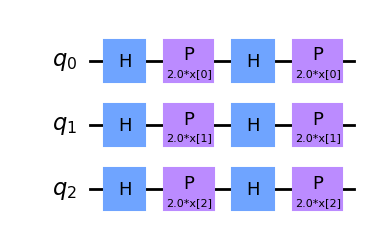

In [8]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

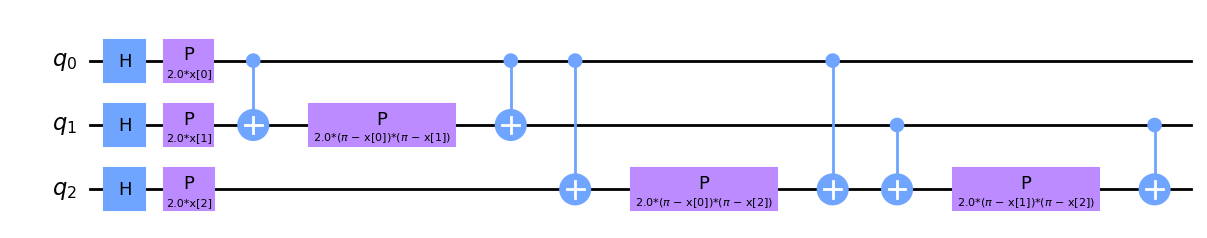

In [9]:
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw('mpl')

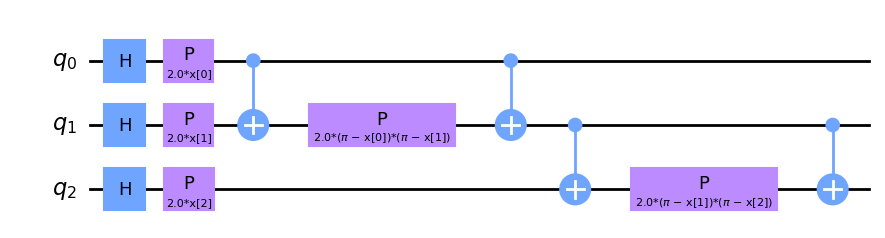

In [10]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

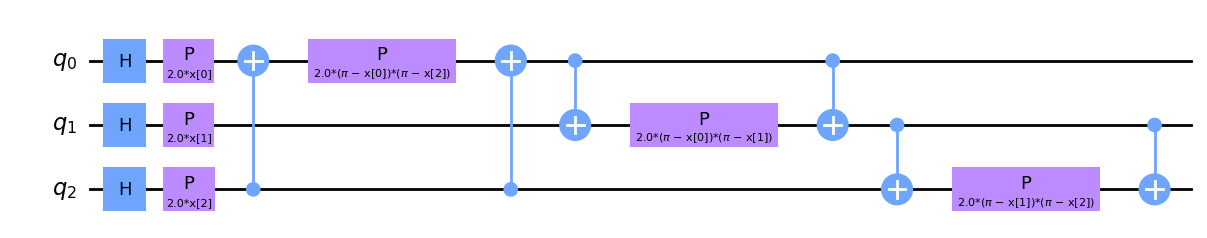

In [11]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

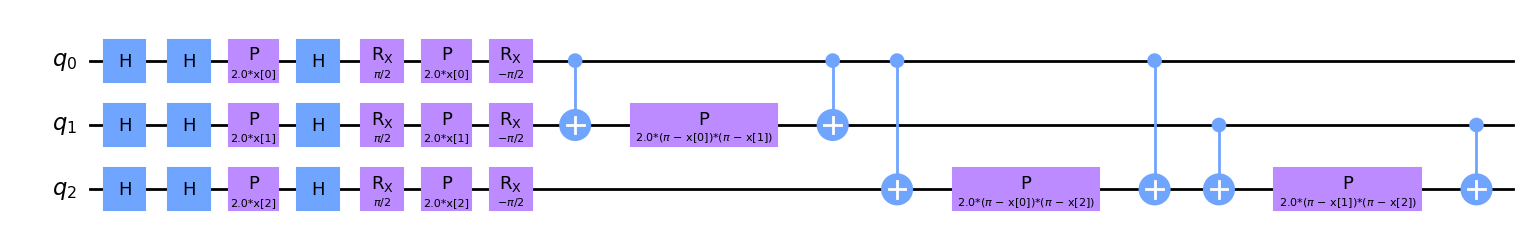

In [12]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

In [13]:
def custom_data_map_func(x):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.sin(np.pi - x))
    return coeff

In [14]:
map_customdatamap = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)

#map_customdatamap.draw() # qiskit isn't able to draw the circuit with np.sin in the custom data map 

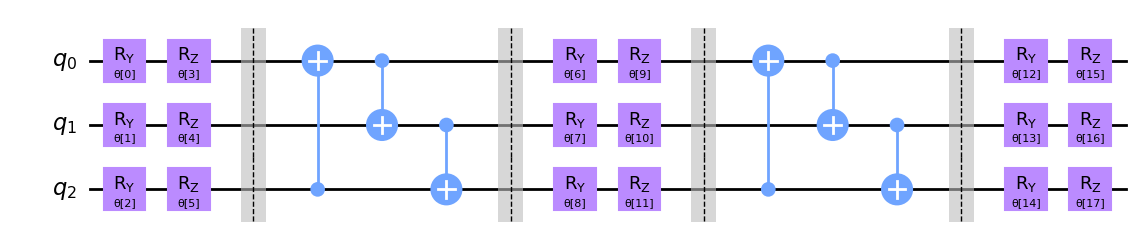

In [15]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

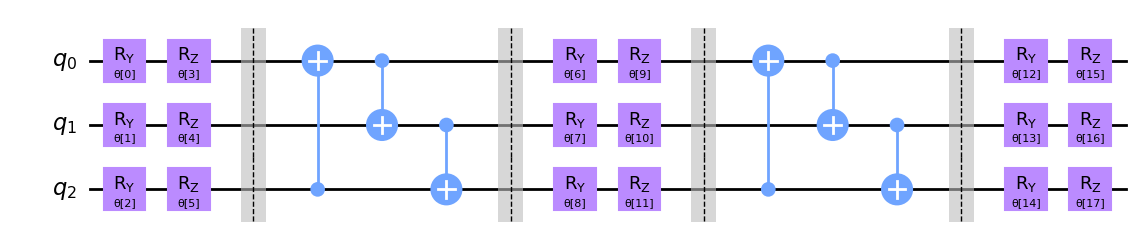

In [16]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

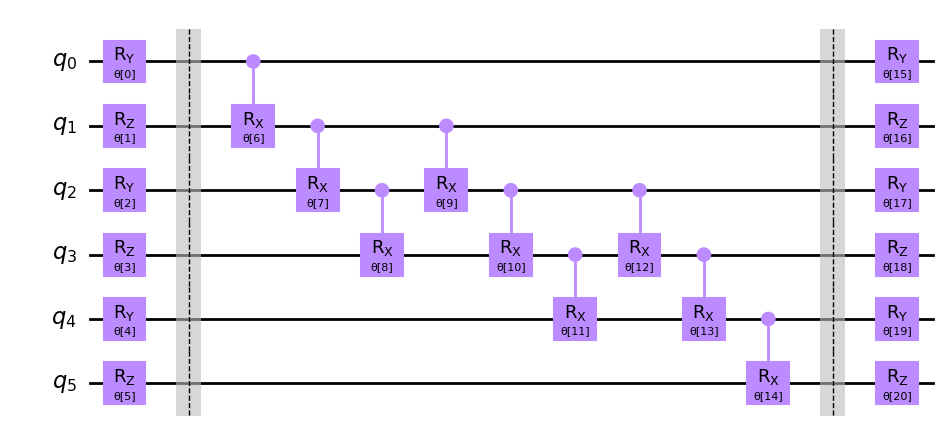

In [17]:
# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

nlocal = NLocal(num_qubits=6, rotation_blocks=rot, entanglement_blocks=ent, 
                entanglement='linear', insert_barriers=True)
nlocal.decompose().draw('mpl')

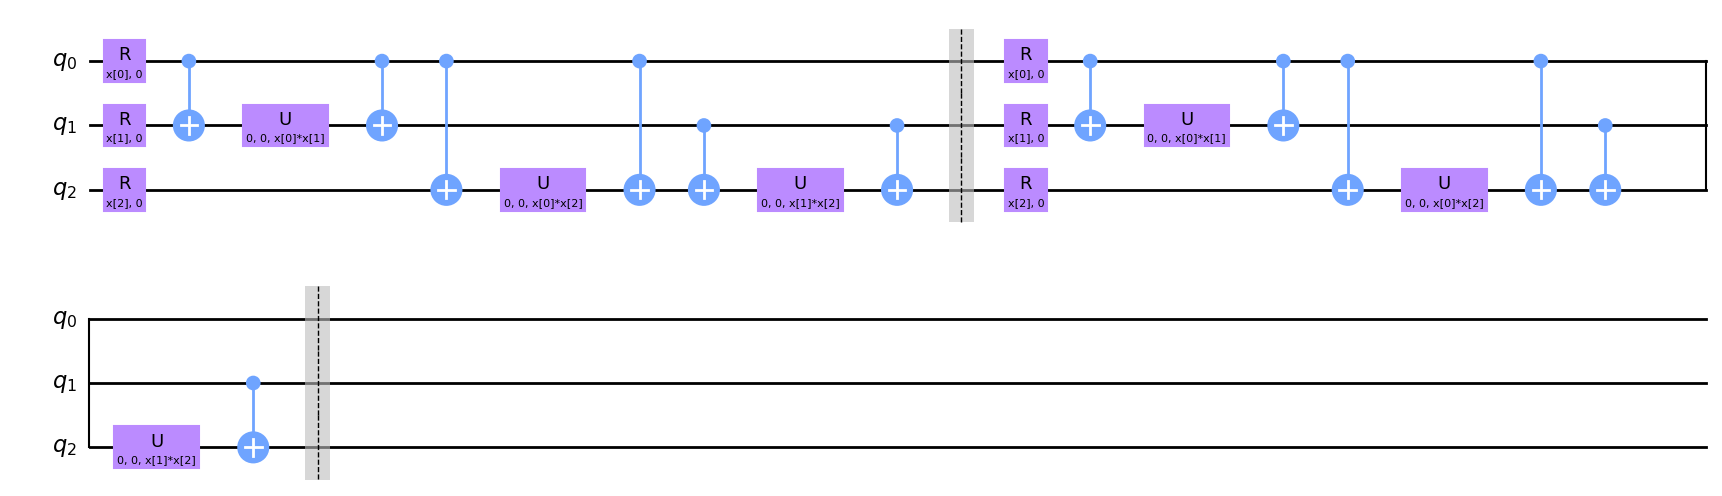

In [15]:
qubits = 3     
repeats = 2

x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)

for _ in range(repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            var_custom.cx(i, j)
            var_custom.p(x[i] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()
            
var_custom.decompose().draw('mpl')

In [16]:
print(sample_train[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]


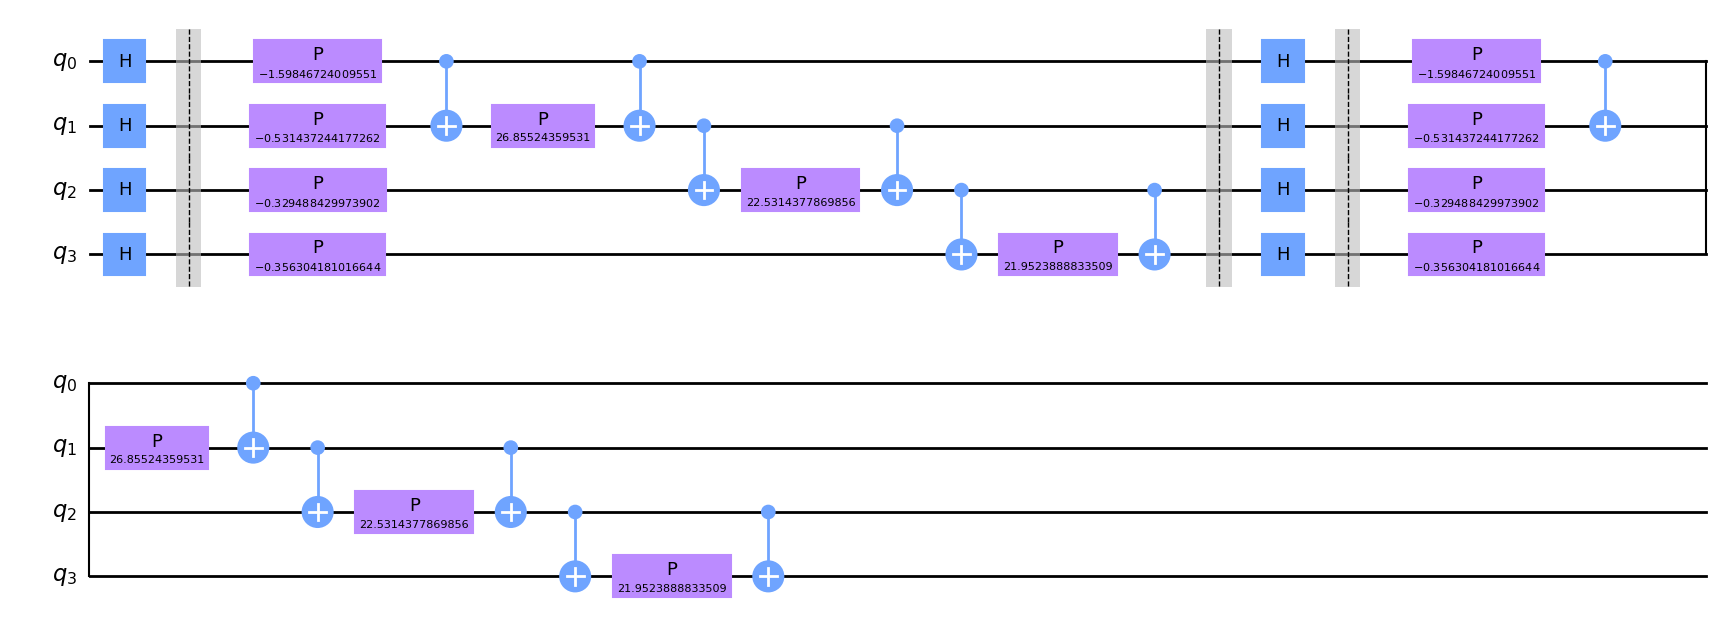

In [17]:
encode_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

In [18]:
from qiskit import BasicAer
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
#zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))
print(sample_train[0])
print(sample_train[1])
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

#backend = Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend('qasm_simulator')

job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


In [19]:
counts['0000']/sum(counts.values())

0.0020751953125

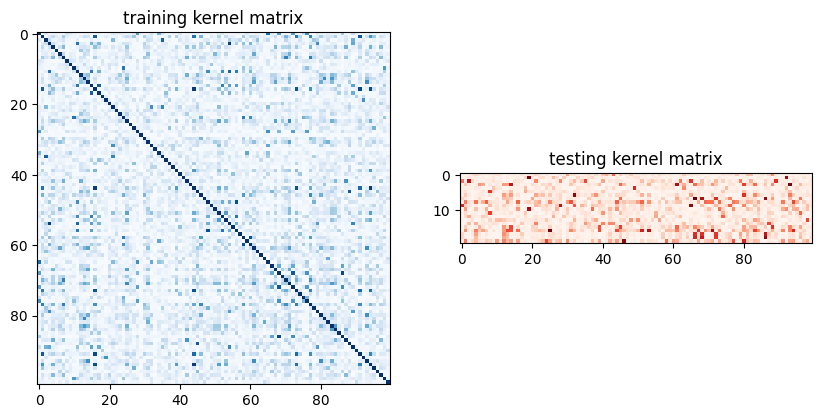

In [20]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [49]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.95


In [50]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 0.95


In [51]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  1.00
poly kernel classification test score:  0.95
rbf kernel classification test score:  1.00
sigmoid kernel classification test score:  1.00


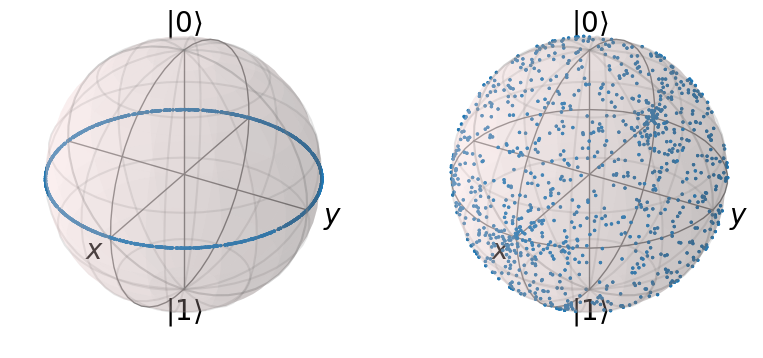

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)

# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.bind_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.bind_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()